# Exploring the argo profile location dataset

This file contains the location of the argo floats profile everytime they surface
The data is extracted from the public FTP ftp://usgodae.org/pub/outgoing/argo/

In [17]:
import os
import urllib.request
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [18]:
# Download the dataset from the website
# Run if needed (~200Mb)
url = ['ftp://usgodae.org/pub/outgoing/argo/ar_index_global_prof.txt',
       'ftp://usgodae.org/pub/outgoing/argo/ar_index_global_traj.txt'
       ]

# this folder has to exist before, you can also just download the data yourself
folder = os.path.expanduser('~/Documents/data/argo/')

# loop on different files to download
for i in range(0, len(url)):
    print('Downloading: ' + str(url[i]))
    response = urllib.request.urlopen(url[i])
    outfile = folder+url[i][36:]
    
    with open(outfile, 'wb') as outfile:
        outfile.write(response.read())

Downloading: ftp://usgodae.org/pub/outgoing/argo/ar_index_global_prof.txt
Downloading: ftp://usgodae.org/pub/outgoing/argo/ar_index_global_traj.txt


In [19]:
file = folder + 'ar_index_global_prof.txt'
df = pd.read_csv(file, sep=',', parse_dates=['date'], skiprows=8)

In [20]:
### Filter dataset

# remove floats without lat/lon data (99999.000 and -999.000) 
non_nan = np.logical_and(df.longitude != 99999.000, df.latitude != 99999.000)
df = df[non_nan]
non_nan = np.logical_and(df.longitude != -999.000, df.latitude != -999.000)
df = df[non_nan]

# remove floats with no date
df = df[df.date.notnull()]

# modify longitudes > 180 to keep between [-180, +180]
df.loc[df.longitude > 180, 'longitude'] -= 360
df.head()

,file,date,latitude,longitude,ocean,profiler_type,institution,date_update
0,aoml/13857/profiles/R13857_001.nc,1997-07-29 20:03:00,0.267,-16.032,A,845,AO,20160401193107
1,aoml/13857/profiles/R13857_002.nc,1997-08-09 19:21:12,0.072,-17.659,A,845,AO,20160401193107
2,aoml/13857/profiles/R13857_003.nc,1997-08-20 18:45:45,0.543,-19.622,A,845,AO,20160401193108
3,aoml/13857/profiles/R13857_004.nc,1997-08-31 19:39:05,1.256,-20.521,A,845,AO,20160401193108
4,aoml/13857/profiles/R13857_005.nc,1997-09-11 18:58:08,0.720,-20.768,A,845,AO,20160401193109


In [21]:
# Create new variables id and datenum

# From the insitution we get the name of the folder from a dictionnary
# to extract the unique float id
def extract_id(filename, institution):
    '''return float id from filename and institution'''
    inst_folder = {'AO': 'aoml/', 'BO': 'bodc/', 'IF': 'coriolis/', 'HZ':'csio/', 'CS':'csiro/', 'IN':'incois/', 
              'JA':'jma/', 'KM':'kma/', 'KO':'kordi/', 'ME':'meds/', 'NM':'nmdis/'}
    id = np.empty_like(filename)
    for i in range(0, len(filename)):
        id[i] = filename[i].replace(inst_folder[institution[i]], '').split('/', 1)[0]
    return id

from datetime import datetime, timedelta
def convert_to_datenum_matlab(date):
    datenum = np.zeros(date.shape)
    for i in range(0, len(date)):
        # convert Panda Timestamp to datetime object
        d = datetime.utcfromtimestamp(date[i].tolist()/1e9)
        ord = d.toordinal()
        mdn = d + timedelta(days = 366)
        frac = (d - datetime(d.year,d.month,d.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
        datenum[i] = mdn.toordinal() + frac
    return datenum


df['id'] = extract_id(df['file'].values, df['institution'].values)
df['datenum'] = convert_to_datenum_matlab(df['date'].values)

In [22]:
output_df = df[['id', 'datenum', 'latitude', 'longitude']].copy()
output_df.to_csv(folder + 'path.csv', sep=',', index=False)
output_df.head()

,id,datenum,latitude,longitude
0,13857,729600.835417,0.267,-16.032
1,13857,729611.806389,0.072,-17.659
2,13857,729622.781771,0.543,-19.622
3,13857,729633.818808,1.256,-20.521
4,13857,729644.790370,0.720,-20.768


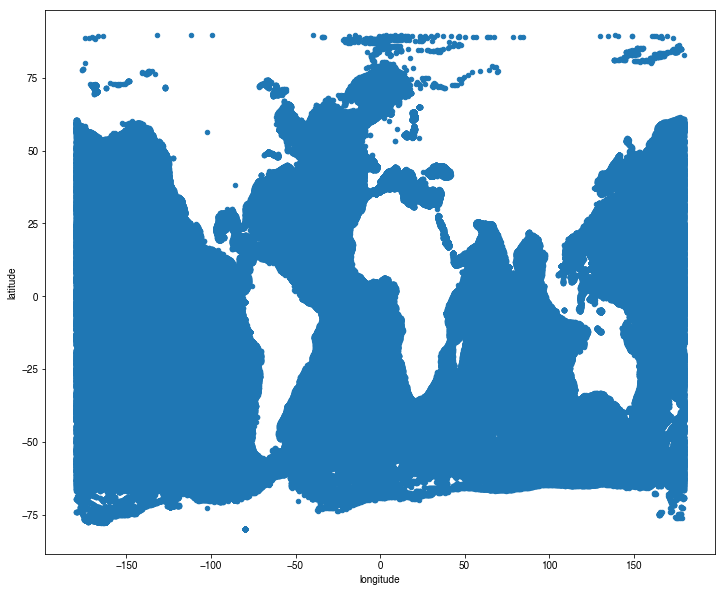

In [23]:
aoml = df.institution == 'AO'
floats = df.loc[aoml]

fig, ax = plt.subplots(figsize=(12,10))
df.plot(kind='scatter', x='longitude', y='latitude', ax=ax)